# UCF101 Skeleton-Based Action Recognition

Notebook refreshed to (1) clarify short warm-up vs. full training, (2) quantify padding impact, and (3) use group-aware splits that avoid leakage between train/val/test.


## 1. Setup and Imports

In [1]:
import os
import sys
import json
import pickle
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import yaml
from tqdm.notebook import tqdm

# Resolve project root whether the notebook is opened from the repo root or /Notebooks
PROJECT_ROOT = os.path.abspath(os.getcwd())
if os.path.basename(PROJECT_ROOT).lower() == "notebooks":
    PROJECT_ROOT = os.path.dirname(PROJECT_ROOT)

sys.path.append(PROJECT_ROOT)

from src.datasets.skeleton_dataset import SkeletonDataset
from src.models.baseline_mlp import create_baseline_model
from src.models.cnn_lstm import create_cnn_lstm_model
from src.utils.seed import set_seed
from src.utils.metrics import compute_metrics, compute_confusion_matrix
from src.utils.plotting import plot_training_curves, plot_confusion_matrix
from src.utils.ucf101_classes import get_class_name, UCF101_CLASSES
from src.utils.split_utils import save_grouped_splits, extract_group_id

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load configs and prepare grouped splits

In [2]:
def resolve_path(path):
    if os.path.isabs(path):
        return path
    return os.path.normpath(os.path.join(PROJECT_ROOT, path))

with open(resolve_path('configs/baseline.yaml'), 'r') as f:
    baseline_config = yaml.safe_load(f)

with open(resolve_path('configs/cnn_lstm.yaml'), 'r') as f:
    cnn_lstm_config = yaml.safe_load(f)

raw_data_path = resolve_path(cnn_lstm_config['dataset']['data_path'])
grouped_data_path = resolve_path(
    cnn_lstm_config['dataset'].get('grouped_output_path', cnn_lstm_config['dataset']['data_path'])
)

base_train_split = cnn_lstm_config['dataset'].get('train_split', 'train1')
group_train_key = cnn_lstm_config['dataset'].get('group_train_key', f"{base_train_split}_grouped_train")
group_val_key = cnn_lstm_config['dataset'].get('group_val_key', f"{base_train_split}_grouped_val")
test_split = cnn_lstm_config['dataset'].get('test_split', 'test1')

save_grouped_splits(
    data_path=raw_data_path,
    output_path=grouped_data_path,
    base_split=base_train_split,
    n_splits=cnn_lstm_config['dataset'].get('group_n_splits', 5),
    fold_idx=cnn_lstm_config['dataset'].get('group_fold_idx', 0),
    random_state=cnn_lstm_config['seed'],
    train_key=group_train_key,
    val_key=group_val_key,
)

# Point configs at the grouped file for the remainder of the notebook
baseline_config['dataset']['data_path'] = grouped_data_path
cnn_lstm_config['dataset']['data_path'] = grouped_data_path

set_seed(cnn_lstm_config['seed'])

cnn_save_dir = resolve_path(cnn_lstm_config['paths']['save_dir'])
os.makedirs(cnn_save_dir, exist_ok=True)

print(f"Grouped dataset path: {grouped_data_path}")
print(f"Train split: {group_train_key} | Val split: {group_val_key} | Test split: {test_split}")

Grouped dataset path: /Users/alexeidelgado/Desktop/PythonProject/data/ucf101_2d_grouped.pkl
Train split: train1_grouped_train | Val split: train1_grouped_val | Test split: test1


## 3. Dataset overview

In [3]:
with open(grouped_data_path, 'rb') as f:
    data = pickle.load(f)

print("Dataset keys:", data.keys())
print("Split sizes:")
for split_name in [group_train_key, group_val_key, test_split]:
    print(f"  {split_name}: {len(data['split'][split_name])} clips")

print(f"Total annotations: {len(data['annotations'])}")

# Show one example annotation
sample = next(ann for ann in data['annotations'] if ann['frame_dir'] in data['split'][group_train_key])
print(f"Sample annotation keys:", sample.keys())
print(f"frame_dir: {sample['frame_dir']}")
print(f"total_frames: {sample['total_frames']}")
print(f"img_shape: {sample['img_shape']}")
print(f"label index: {sample['label']} -> {get_class_name(sample['label'])}")
print(f"keypoint shape: {sample['keypoint'].shape}")

Dataset keys: dict_keys(['split', 'annotations'])
Split sizes:
  train1_grouped_train: 7948 clips
  train1_grouped_val: 1589 clips
  test1: 3783 clips
Total annotations: 13320
Sample annotation keys: dict_keys(['keypoint', 'keypoint_score', 'frame_dir', 'total_frames', 'original_shape', 'img_shape', 'label'])
frame_dir: v_ApplyEyeMakeup_g08_c01
total_frames: 119
img_shape: (256, 340)
label index: 0 -> ApplyEyeMakeup
keypoint shape: (1, 119, 17, 2)


## 4. Sequence lengths and padding impact

Target frames per clip: 64
Clips shorter than target: 2.91%
Avg frames missing (short clips): 0.34
Padded frames / total frames across dataset: 0.53%


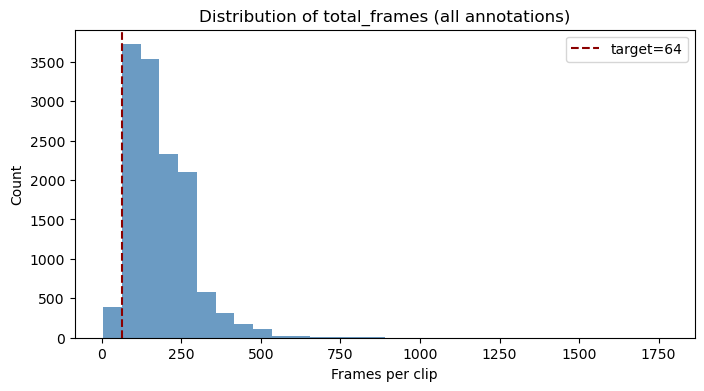

In [4]:
seq_lengths = np.array([ann['total_frames'] for ann in data['annotations']])
target_frames = cnn_lstm_config['dataset']['num_frames']
pct_shorter = (seq_lengths < target_frames).mean() * 100
avg_missing = np.maximum(target_frames - seq_lengths, 0).mean()
padded_frame_fraction = np.maximum(target_frames - seq_lengths, 0).sum() / (len(seq_lengths) * target_frames)

print(f"Target frames per clip: {target_frames}")
print(f"Clips shorter than target: {pct_shorter:.2f}%")
print(f"Avg frames missing (short clips): {avg_missing:.2f}")
print(f"Padded frames / total frames across dataset: {padded_frame_fraction * 100:.2f}%")

plt.figure(figsize=(8,4))
plt.hist(seq_lengths, bins=30, color='steelblue', alpha=0.8)
plt.axvline(target_frames, color='darkred', linestyle='--', label=f'target={target_frames}')
plt.title('Distribution of total_frames (all annotations)')
plt.xlabel('Frames per clip')
plt.ylabel('Count')
plt.legend()
plt.show()

## 5. Group-aware split sanity check (no leakage)

In [5]:
def groups_for_split(split_name):
    ids = set(data['split'][split_name])
    return {extract_group_id(ann['frame_dir']) for ann in data['annotations'] if ann['frame_dir'] in ids}

train_groups = groups_for_split(group_train_key)
val_groups = groups_for_split(group_val_key)
test_groups = groups_for_split(test_split)

print(f"Train groups: {len(train_groups)} | Val groups: {len(val_groups)} | Test groups: {len(test_groups)}")
print(f"Train ∩ Val groups: {train_groups & val_groups}")
print(f"Train ∩ Test groups: {train_groups & test_groups}")
print(f"Val ∩ Test groups: {val_groups & test_groups}")

Train groups: 15 | Val groups: 3 | Test groups: 7
Train ∩ Val groups: set()
Train ∩ Test groups: set()
Val ∩ Test groups: set()


## 6. Build dataloaders

In [6]:
common_dataset_kwargs = dict(
    data_path=grouped_data_path,
    num_frames=cnn_lstm_config['dataset']['num_frames'],
    num_joints=cnn_lstm_config['dataset']['num_joints'],
    num_coords=cnn_lstm_config['dataset']['num_coords'],
    class_names=cnn_lstm_config['dataset']['class_names'],
)

train_dataset = SkeletonDataset(split=group_train_key, **common_dataset_kwargs)
val_dataset = SkeletonDataset(split=group_val_key, **common_dataset_kwargs)
test_dataset = SkeletonDataset(split=test_split, **common_dataset_kwargs)

batch_size = cnn_lstm_config['training']['batch_size']
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Train batches: {len(train_dataloader)} | Val batches: {len(val_dataloader)} | Test batches: {len(test_dataloader)}")

Train batches: 249 | Val batches: 50 | Test batches: 119


### Inspect a batch

In [7]:
batch_skeletons, batch_labels = next(iter(train_dataloader))
print(f"Skeleton batch shape: {batch_skeletons.shape}")
print(f"Labels shape: {batch_labels.shape}")
for i in range(min(5, len(batch_labels))):
    print(f"Sample {i}: Label {batch_labels[i].item()} ({get_class_name(batch_labels[i].item())})")

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Skeleton batch shape: torch.Size([32, 64, 34])
Labels shape: torch.Size([32])
Sample 0: Label 10 (Biking)
Sample 1: Label 94 (Typing)
Sample 2: Label 35 (HammerThrow)
Sample 3: Label 5 (BandMarching)
Sample 4: Label 67 (PoleVault)


## 7. Training helpers (shared by warm-up and full runs)

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    all_preds, all_labels = [], []

    for skeletons, labels in tqdm(dataloader, desc="Train", leave=False):
        skeletons = skeletons.to(device)
        labels = labels.to(device)

        outputs = model(skeletons)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    metrics = compute_metrics(all_labels, all_preds)
    return epoch_loss / len(dataloader), metrics['accuracy'], metrics


def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for skeletons, labels in tqdm(dataloader, desc="Val", leave=False):
            skeletons = skeletons.to(device)
            labels = labels.to(device)

            outputs = model(skeletons)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = compute_metrics(all_labels, all_preds)
    return val_loss / len(dataloader), metrics['accuracy'], metrics


def run_training(model, config, train_loader, val_loader, save_dir, max_epochs=None, early_stop_patience=None):
    os.makedirs(save_dir, exist_ok=True)

    train_cfg = config['training']
    num_epochs = max_epochs or train_cfg['num_epochs']
    patience = early_stop_patience or train_cfg['early_stopping_patience']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=train_cfg['learning_rate'],
        weight_decay=train_cfg['weight_decay'],
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=train_cfg['scheduler_factor'],
        patience=train_cfg['scheduler_patience'],
        min_lr=train_cfg['scheduler_min_lr'],
    )

    best_val_accuracy = 0.0
    best_state = None
    early_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print(f"Starting training for up to {num_epochs} epochs (patience={patience})")
    for epoch in range(num_epochs):
        train_loss, train_acc, _ = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_metrics = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")

        if val_acc >= best_val_accuracy:
            best_val_accuracy = val_acc
            best_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
                'val_metrics': val_metrics,
            }
            torch.save(best_state, os.path.join(save_dir, 'best_model.pth'))
            early_counter = 0
        else:
            early_counter += 1

        if early_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    final_ckpt = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_accuracy': val_acc,
        'val_metrics': val_metrics,
    }
    torch.save(final_ckpt, os.path.join(save_dir, 'final_model.pth'))

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies,
        'best_val_accuracy': best_val_accuracy,
        'best_epoch': int(np.argmax(val_accuracies)) + 1,
    }

    with open(os.path.join(save_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f, indent=2)

    plot_training_curves(
        train_losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        save_path=os.path.join(save_dir, 'training_curves.png'),
    )

    if best_state:
        model.load_state_dict(best_state['model_state_dict'])

    return model, history


def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for skeletons, labels in tqdm(dataloader, desc="Evaluate"):
            outputs = model(skeletons.to(device))
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    metrics = compute_metrics(all_labels, all_preds)
    cm = compute_confusion_matrix(all_labels, all_preds)
    return metrics, cm, np.array(all_preds), np.array(all_labels)

## 8. Optional: 5-epoch warm-up (for quick sanity checks)

In [9]:
run_warmup = False
warmup_history = None
warmup_model = None

if run_warmup:
    warmup_model = create_cnn_lstm_model(cnn_lstm_config['model']).to(device)
    warmup_model, warmup_history = run_training(
        warmup_model,
        cnn_lstm_config,
        train_dataloader,
        val_dataloader,
        save_dir=os.path.join(cnn_save_dir, 'warmup'),
        max_epochs=5,
        early_stop_patience=2,
    )
else:
    print("Warm-up skipped; set run_warmup=True to reproduce the short 5-epoch sanity run.")

Warm-up skipped; set run_warmup=True to reproduce the short 5-epoch sanity run.


## 9. Full training until convergence (grouped splits)

Starting training for up to 150 epochs (patience=15)


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/150 | Train loss 4.2531 acc 0.0396 | Val loss 3.7449 acc 0.0975


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 2/150 | Train loss 3.7146 acc 0.0765 | Val loss 3.4435 acc 0.1158


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 3/150 | Train loss 3.4778 acc 0.1051 | Val loss 3.2889 acc 0.1529


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 4/150 | Train loss 3.3339 acc 0.1288 | Val loss 3.1929 acc 0.1630


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 5/150 | Train loss 3.1613 acc 0.1594 | Val loss 3.0580 acc 0.1932


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 6/150 | Train loss 3.0248 acc 0.1860 | Val loss 2.9222 acc 0.2152


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7/150 | Train loss 2.8829 acc 0.2300 | Val loss 2.8791 acc 0.2335


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 8/150 | Train loss 2.7473 acc 0.2490 | Val loss 2.8060 acc 0.2593


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 9/150 | Train loss 2.6417 acc 0.2733 | Val loss 2.6810 acc 0.3008


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/150 | Train loss 2.4855 acc 0.3119 | Val loss 2.6215 acc 0.3279


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 11/150 | Train loss 2.3810 acc 0.3393 | Val loss 2.6381 acc 0.3134


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 12/150 | Train loss 2.2700 acc 0.3577 | Val loss 2.5390 acc 0.3392


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 13/150 | Train loss 2.1453 acc 0.3937 | Val loss 2.5246 acc 0.3424


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 14/150 | Train loss 2.0639 acc 0.4142 | Val loss 2.4494 acc 0.3631


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 15/150 | Train loss 1.9647 acc 0.4391 | Val loss 2.4587 acc 0.3726


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 16/150 | Train loss 1.8563 acc 0.4677 | Val loss 2.4845 acc 0.3707


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 17/150 | Train loss 1.7685 acc 0.4975 | Val loss 2.4426 acc 0.3940


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 18/150 | Train loss 1.6936 acc 0.5147 | Val loss 2.5253 acc 0.3845


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 19/150 | Train loss 1.5981 acc 0.5361 | Val loss 2.5063 acc 0.4097


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 20/150 | Train loss 1.5545 acc 0.5410 | Val loss 2.5134 acc 0.3927


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 21/150 | Train loss 1.4703 acc 0.5718 | Val loss 2.5579 acc 0.4216


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 22/150 | Train loss 1.3970 acc 0.5966 | Val loss 2.5537 acc 0.3946


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 23/150 | Train loss 1.3197 acc 0.6130 | Val loss 2.5085 acc 0.4053


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 24/150 | Train loss 1.2645 acc 0.6302 | Val loss 2.6200 acc 0.4034


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 25/150 | Train loss 1.1812 acc 0.6475 | Val loss 2.5685 acc 0.4198


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 26/150 | Train loss 0.9415 acc 0.7177 | Val loss 2.5196 acc 0.4487


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 27/150 | Train loss 0.8708 acc 0.7426 | Val loss 2.5770 acc 0.4531


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 28/150 | Train loss 0.8029 acc 0.7584 | Val loss 2.6359 acc 0.4600


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 29/150 | Train loss 0.7663 acc 0.7685 | Val loss 2.6991 acc 0.4682


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 30/150 | Train loss 0.7385 acc 0.7700 | Val loss 2.7980 acc 0.4550


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 31/150 | Train loss 0.6897 acc 0.7869 | Val loss 2.8465 acc 0.4556


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 32/150 | Train loss 0.6697 acc 0.7923 | Val loss 2.9019 acc 0.4569


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 33/150 | Train loss 0.6528 acc 0.7976 | Val loss 2.9194 acc 0.4487


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 34/150 | Train loss 0.6190 acc 0.8052 | Val loss 2.9415 acc 0.4581


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 35/150 | Train loss 0.6045 acc 0.8149 | Val loss 2.9411 acc 0.4581


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 36/150 | Train loss 0.6044 acc 0.8152 | Val loss 2.9478 acc 0.4512


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 37/150 | Train loss 0.5939 acc 0.8137 | Val loss 2.9699 acc 0.4512


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 38/150 | Train loss 0.5988 acc 0.8173 | Val loss 2.9904 acc 0.4556


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 39/150 | Train loss 0.5881 acc 0.8181 | Val loss 2.9978 acc 0.4588


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 40/150 | Train loss 0.5958 acc 0.8138 | Val loss 2.9837 acc 0.4588


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 41/150 | Train loss 0.5842 acc 0.8221 | Val loss 3.0163 acc 0.4581


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 42/150 | Train loss 0.5810 acc 0.8183 | Val loss 3.0201 acc 0.4600


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 43/150 | Train loss 0.5896 acc 0.8152 | Val loss 3.0236 acc 0.4588


Train:   0%|          | 0/249 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 44/150 | Train loss 0.5755 acc 0.8192 | Val loss 3.0375 acc 0.4569
Early stopping at epoch 44


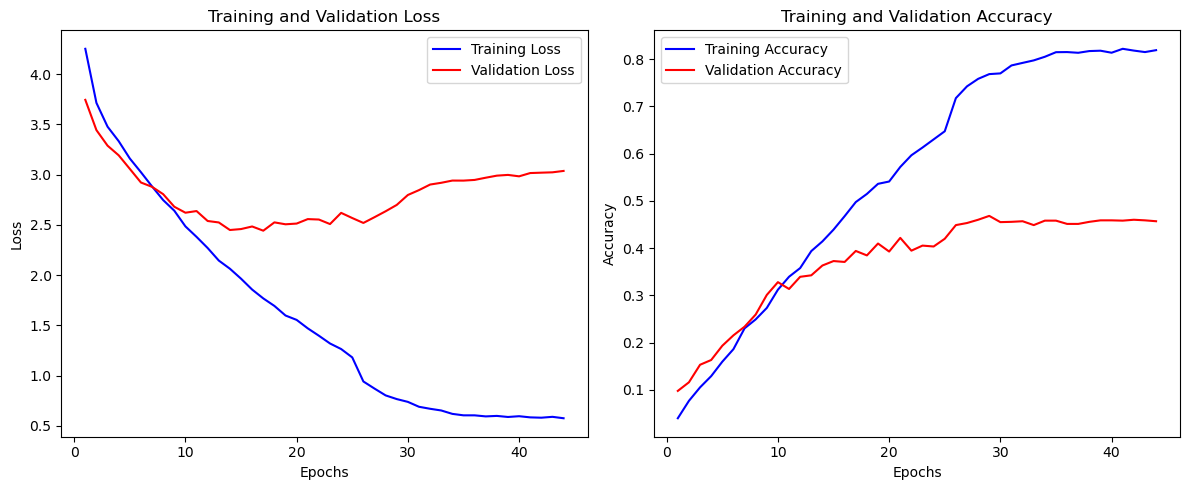

In [12]:
full_history_path = os.path.join(cnn_save_dir, 'training_history.json')
best_model_path = os.path.join(cnn_save_dir, 'best_model.pth')

full_model = create_cnn_lstm_model(cnn_lstm_config['model']).to(device)
full_history = None

if os.path.exists(full_history_path) and os.path.exists(best_model_path):
    with open(full_history_path, 'r') as f:
        full_history = json.load(f)
    checkpoint = torch.load(best_model_path, map_location=device)
    full_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded existing full run from epoch {checkpoint.get('epoch', 'N/A')} with val acc {checkpoint.get('val_accuracy', 0):.4f}")
else:
    full_model, full_history = run_training(
        full_model,
        cnn_lstm_config,
        train_dataloader,
        val_dataloader,
        save_dir=cnn_save_dir,
        max_epochs=cnn_lstm_config['training']['num_epochs'],
        early_stop_patience=cnn_lstm_config['training']['early_stopping_patience'],
    )

## 10. Training curves and validation summary

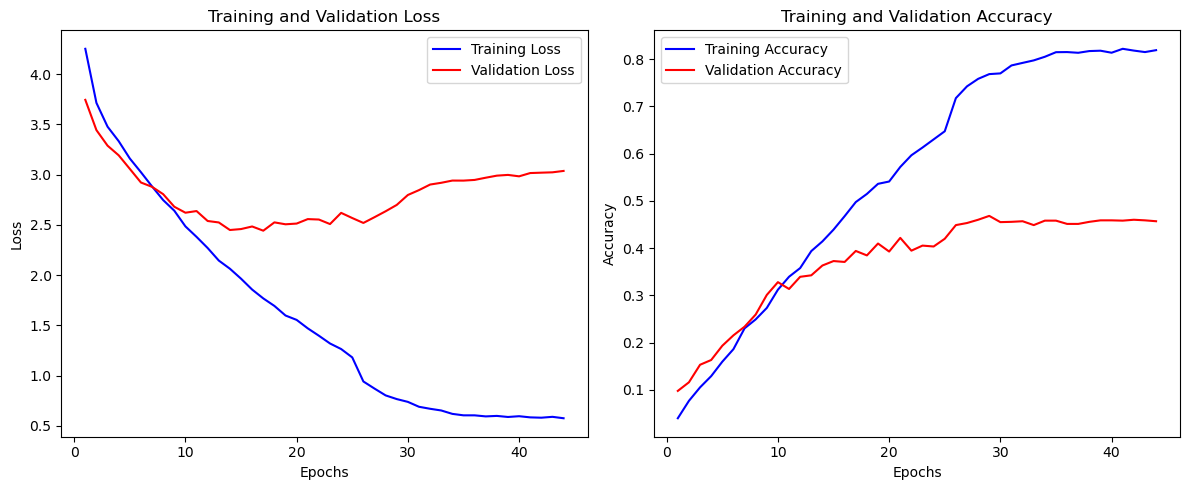

Best val accuracy: 0.4682 (epoch 29)


In [13]:
if full_history is None:
    with open(full_history_path, 'r') as f:
        full_history = json.load(f)

plot_training_curves(
    full_history['train_loss'],
    full_history['val_loss'],
    full_history['train_accuracy'],
    full_history['val_accuracy'],
    save_path=os.path.join(cnn_save_dir, 'training_curves.png'),
)

print(f"Best val accuracy: {full_history['best_val_accuracy']:.4f} (epoch {full_history['best_epoch']})")

## 11. Evaluate best model on held-out test set

Evaluate:   0%|          | 0/119 [00:00<?, ?it/s]

/Users/alexeidelgado/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics:
  accuracy: 0.4309
  precision: 0.4295
  recall: 0.4267
  f1: 0.4197


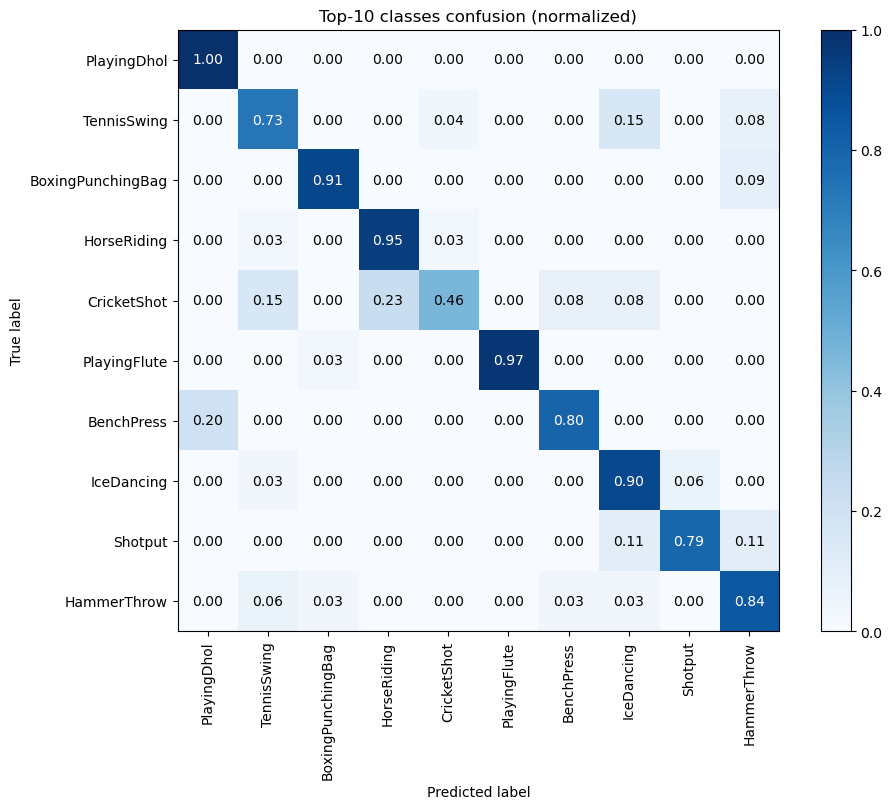

In [14]:
test_metrics, test_cm, test_preds, test_labels = evaluate_model(full_model, test_dataloader, device)

print("Test metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

class_counts = np.bincount(test_labels, minlength=len(UCF101_CLASSES))
top_classes = np.argsort(class_counts)[-10:][::-1]

plot_confusion_matrix(
    test_cm[np.ix_(top_classes, top_classes)],
    [UCF101_CLASSES[i] for i in top_classes],
    normalize=True,
    title='Top-10 classes confusion (normalized)'
)

## 11b. Warm-up vs full run (provenance check)

In [15]:
summary_rows = []

if warmup_history is not None:
    warmup_test_metrics = None
    if warmup_model is not None:
        warmup_test_metrics, _, _, _ = evaluate_model(warmup_model, test_dataloader, device)
    summary_rows.append({
        'run': 'Warm-up (5 epochs)',
        'val_acc': warmup_history['best_val_accuracy'],
        'test_acc': None if warmup_test_metrics is None else warmup_test_metrics['accuracy'],
    })

summary_rows.append({
    'run': 'Full (grouped splits)',
    'val_acc': full_history['best_val_accuracy'],
    'test_acc': test_metrics['accuracy'],
})

pd.DataFrame(summary_rows)

,run,val_acc,test_acc
0,Full (grouped splits),0.468219,0.430875


## 12. Padding reflection

In [16]:
print(f"{pct_shorter:.2f}% of clips are shorter than {target_frames} frames.")
print(f"Average missing frames (padded per clip): {avg_missing:.2f}")
print(f"Overall padded-frame fraction: {padded_frame_fraction * 100:.2f}% of all frames seen by the model.")
print("Takeaway: padding is limited in magnitude but still injects empty timesteps; consider masks or reducing num_frames if this proves harmful.")

2.91% of clips are shorter than 64 frames.
Average missing frames (padded per clip): 0.34
Overall padded-frame fraction: 0.53% of all frames seen by the model.
Takeaway: padding is limited in magnitude but still injects empty timesteps; consider masks or reducing num_frames if this proves harmful.


## 13. Conclusions (update after full run)

- La ejecución completa de CNN+LSTM (con group-aware splits) es el resultado principal; el warm-up opcional de 5 épocas es solo una prueba preliminar.
- El rendimiento de validación/prueba mostrado arriba proviene de la división agrupada, que evita fugas entre entrenamiento y validación a nivel de grupo.
- El zero-padding afecta aproximadamente al porcentaje indicado arriba; trabajos futuros podrían experimentar con máscaras de fotogramas o un num_frames más corto para reducir los timesteps rellenados.
- Próximas mejoras rápidas: ajustar la augmentación, añadir máscaras de validez de fotogramas y considerar variantes 3D GCN/transformer si se necesita más capacidad.


A lo largo del entrenamiento del modelo CNN+LSTM con group-aware splits, se observó un progreso inicial sólido, alcanzando su mejor rendimiento en validación en la época 29 con una exactitud del 46.82%. Sin embargo, a partir de ese punto la brecha entre entrenamiento y validación comenzó a ampliarse, reflejando signos de sobreajuste que finalmente llevaron al early stopping en la época 44 (train acc 0.8192 frente a val acc 0.4569). La evaluación final en el conjunto de prueba mostró un rendimiento moderado, con una exactitud del 43.09% y métricas equilibradas (precision 0.4295, recall 0.4267, f1 0.4197), lo que indica que el modelo captura parcialmente la variabilidad de las acciones, aunque aún enfrenta confusiones notables entre clases. En cuanto al preprocesamiento temporal, solo el 2.91% de los clips resultaron más cortos que los 64 fotogramas requeridos, generando un promedio de 0.34 fotogramas rellenados por clip y una fracción total mínima del 0.53% de padded frames. Si bien el impacto del padding es reducido, sigue introduciendo timesteps vacíos que podrían afectar la dinámica temporal del modelo; por ello, futuras mejoras deberían considerar máscaras de validez o la reducción de num_frames. En conjunto, estos resultados muestran que el pipeline es funcional y estable, pero que el rendimiento final depende críticamente de mejoras en regularización, aumento de datos y posiblemente arquitecturas con mayor capacidad temporal como convoluciones temporales.